In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import torch

import warnings
sns.set_style("ticks")
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'seaborn'

## Generate Data

In [118]:
dims = [10, 100, 500]

In [119]:
from sklearn.datasets import make_classification, make_blobs
# Cluster of points normally distributed (std=1) about vertices
# of an n_informative-dim hypercube with sides of length 2*class_sep

# Features are ordered: n_informative, n_redundant, n_repeated, 
# then random noise
def generate_samples(n_features, n_informative, n_samples=100):
    """
    return make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=2,
        random_state=42
        
    )
    """
    return make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative,
        n_redundant=0, 
        n_repeated=0, 
        n_classes=2, 
        n_clusters_per_class=1, 
        flip_y=0.01, 
        class_sep=2, 
        random_state=42,
        shuffle=False
    )

X = dict()
y = dict()
for i in dims:
    X[i], y[i] = generate_samples(i, i)

### Projection onto 2 Dimensions

In [120]:
from sklearn.decomposition import PCA

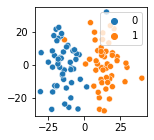

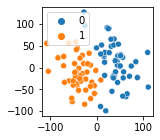

In [121]:
pca = dict()
X_reduced = dict()

for i in dims:
    pca[i] = PCA(n_components=2)
    X_reduced[i] = pca[i].fit_transform(X[i])
    plt.figure(figsize=(2,2))
    sns.scatterplot(x=X_reduced[i][:,0], y=X_reduced[i][:,1], hue=y[i])

## Linear Separator

In [122]:
from sklearn.svm import LinearSVC

clf = dict()
for i in dims:
    clf[i] = LinearSVC(random_state=42, max_iter=1000)
    clf[i].fit(X[i], y[i])

In [123]:
for i in dims:
    y[i][y[i] == 0] = -1
    y[i]

In [124]:
w_norm = dict()
for i in dims:
    w_norm[i] = np.linalg.norm(clf[i].coef_)

### Reload Training Data

In [179]:
X_sel = dict()
y_sel = dict()
for i in dims:
    rs = ShuffleSplit(n_splits=1, train_size=16, random_state=42)
    # Recover the exact indices used for training (kind of hacky)
    for train_index, test_index in rs.split(X[i]):
        X_sel[i], y_sel[i] = X[i][train_index], y[i][train_index]

### Reload Best Attacker Data and Plot Graphs

In [173]:
def get_raw_report(ada, lamb, dim):
    if ada:
        report = torch.load(f"gaussian_adazoro_lambda{lamb}_d{dim}_20220616_report.pt")
    else:
        report = torch.load(f"gaussian_zoro_lambda{lamb}_d{dim}_20220616_report.pt")

    return report

def compile_report(ada, lamb, dim):
    report = get_raw_report(ada, lamb, dim)
    
    data_point = []

    iteration = []
    number_evals = []
    perturbation_norms = []
    predictions = []
    labels = []

    for i in range(len(report)):
        data_point.extend([i] * len(report[i]))
        original = report[i][0]["x"]
        labels.extend([report[i][0]["y"]] * len(report[i]))

        iteration.extend(range(len(report[i])))
        number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
        perturbation_norms.extend([np.linalg.norm(original - report[i][j]["x"], 2) for j in range(len(report[i]))])
        predictions.extend(clf[dim].decision_function(np.stack([report[i][j]["x"] for j in range(len(report[i]))]))/w_norm[dim].tolist())

    results_df = pd.DataFrame(
        {"data_point" : data_point,
         "iteration" : iteration,
         "num_function_evals": number_evals,
         "perturbation_norm": perturbation_norms,
         "distance_to_boundary": predictions,
         "label" : labels,
         "optimizer": len(labels) * ["AdaZORO" if ada else "ZORO"],
         "lambda" : len(labels) * [lamb],
         "dimensionality" : len(labels) * [dim]
        }
    )
    
    return results_df

In [160]:
report_ada_d100_lamb_01 = compile_report(True, 0.01, 100)
report_ada_d100_lamb_05 = compile_report(True, 0.05, 100)
report_ada_d100_lamb_10 = compile_report(True, 0.10, 100)

#report_ada_d10_lamb_01 = compile_report(True, 0.01, 10)
#report_ada_d10_lamb_05 = compile_report(True, 0.05, 10)
#report_ada_d10_lamb_10 = compile_report(True, 0.10, 10)

report_zoro_d100_lamb_01 = compile_report(False, 0.01, 100)
report_zoro_d100_lamb_05 = compile_report(False, 0.05, 100)
report_zoro_d100_lamb_10 = compile_report(False, 0.10, 100)

#report_zoro_d10_lamb_01 = compile_report(False, 0.01, 10)
#report_zoro_d10_lamb_05 = compile_report(False, 0.05, 10)
#report_zoro_d10_lamb_10 = compile_report(False, 0.10, 10)

In [161]:
report_all = pd.concat([report_ada_d100_lamb_01,
                            report_ada_d100_lamb_05,
                            report_ada_d100_lamb_10,
                            report_zoro_d100_lamb_01,
                            report_zoro_d100_lamb_05,
                            report_zoro_d100_lamb_10]).reset_index()

#### Fig 1

PCA of Example Point:
1. Original Cluster 1
2. Original Cluster 2
3. Trace of Attack over Iterations

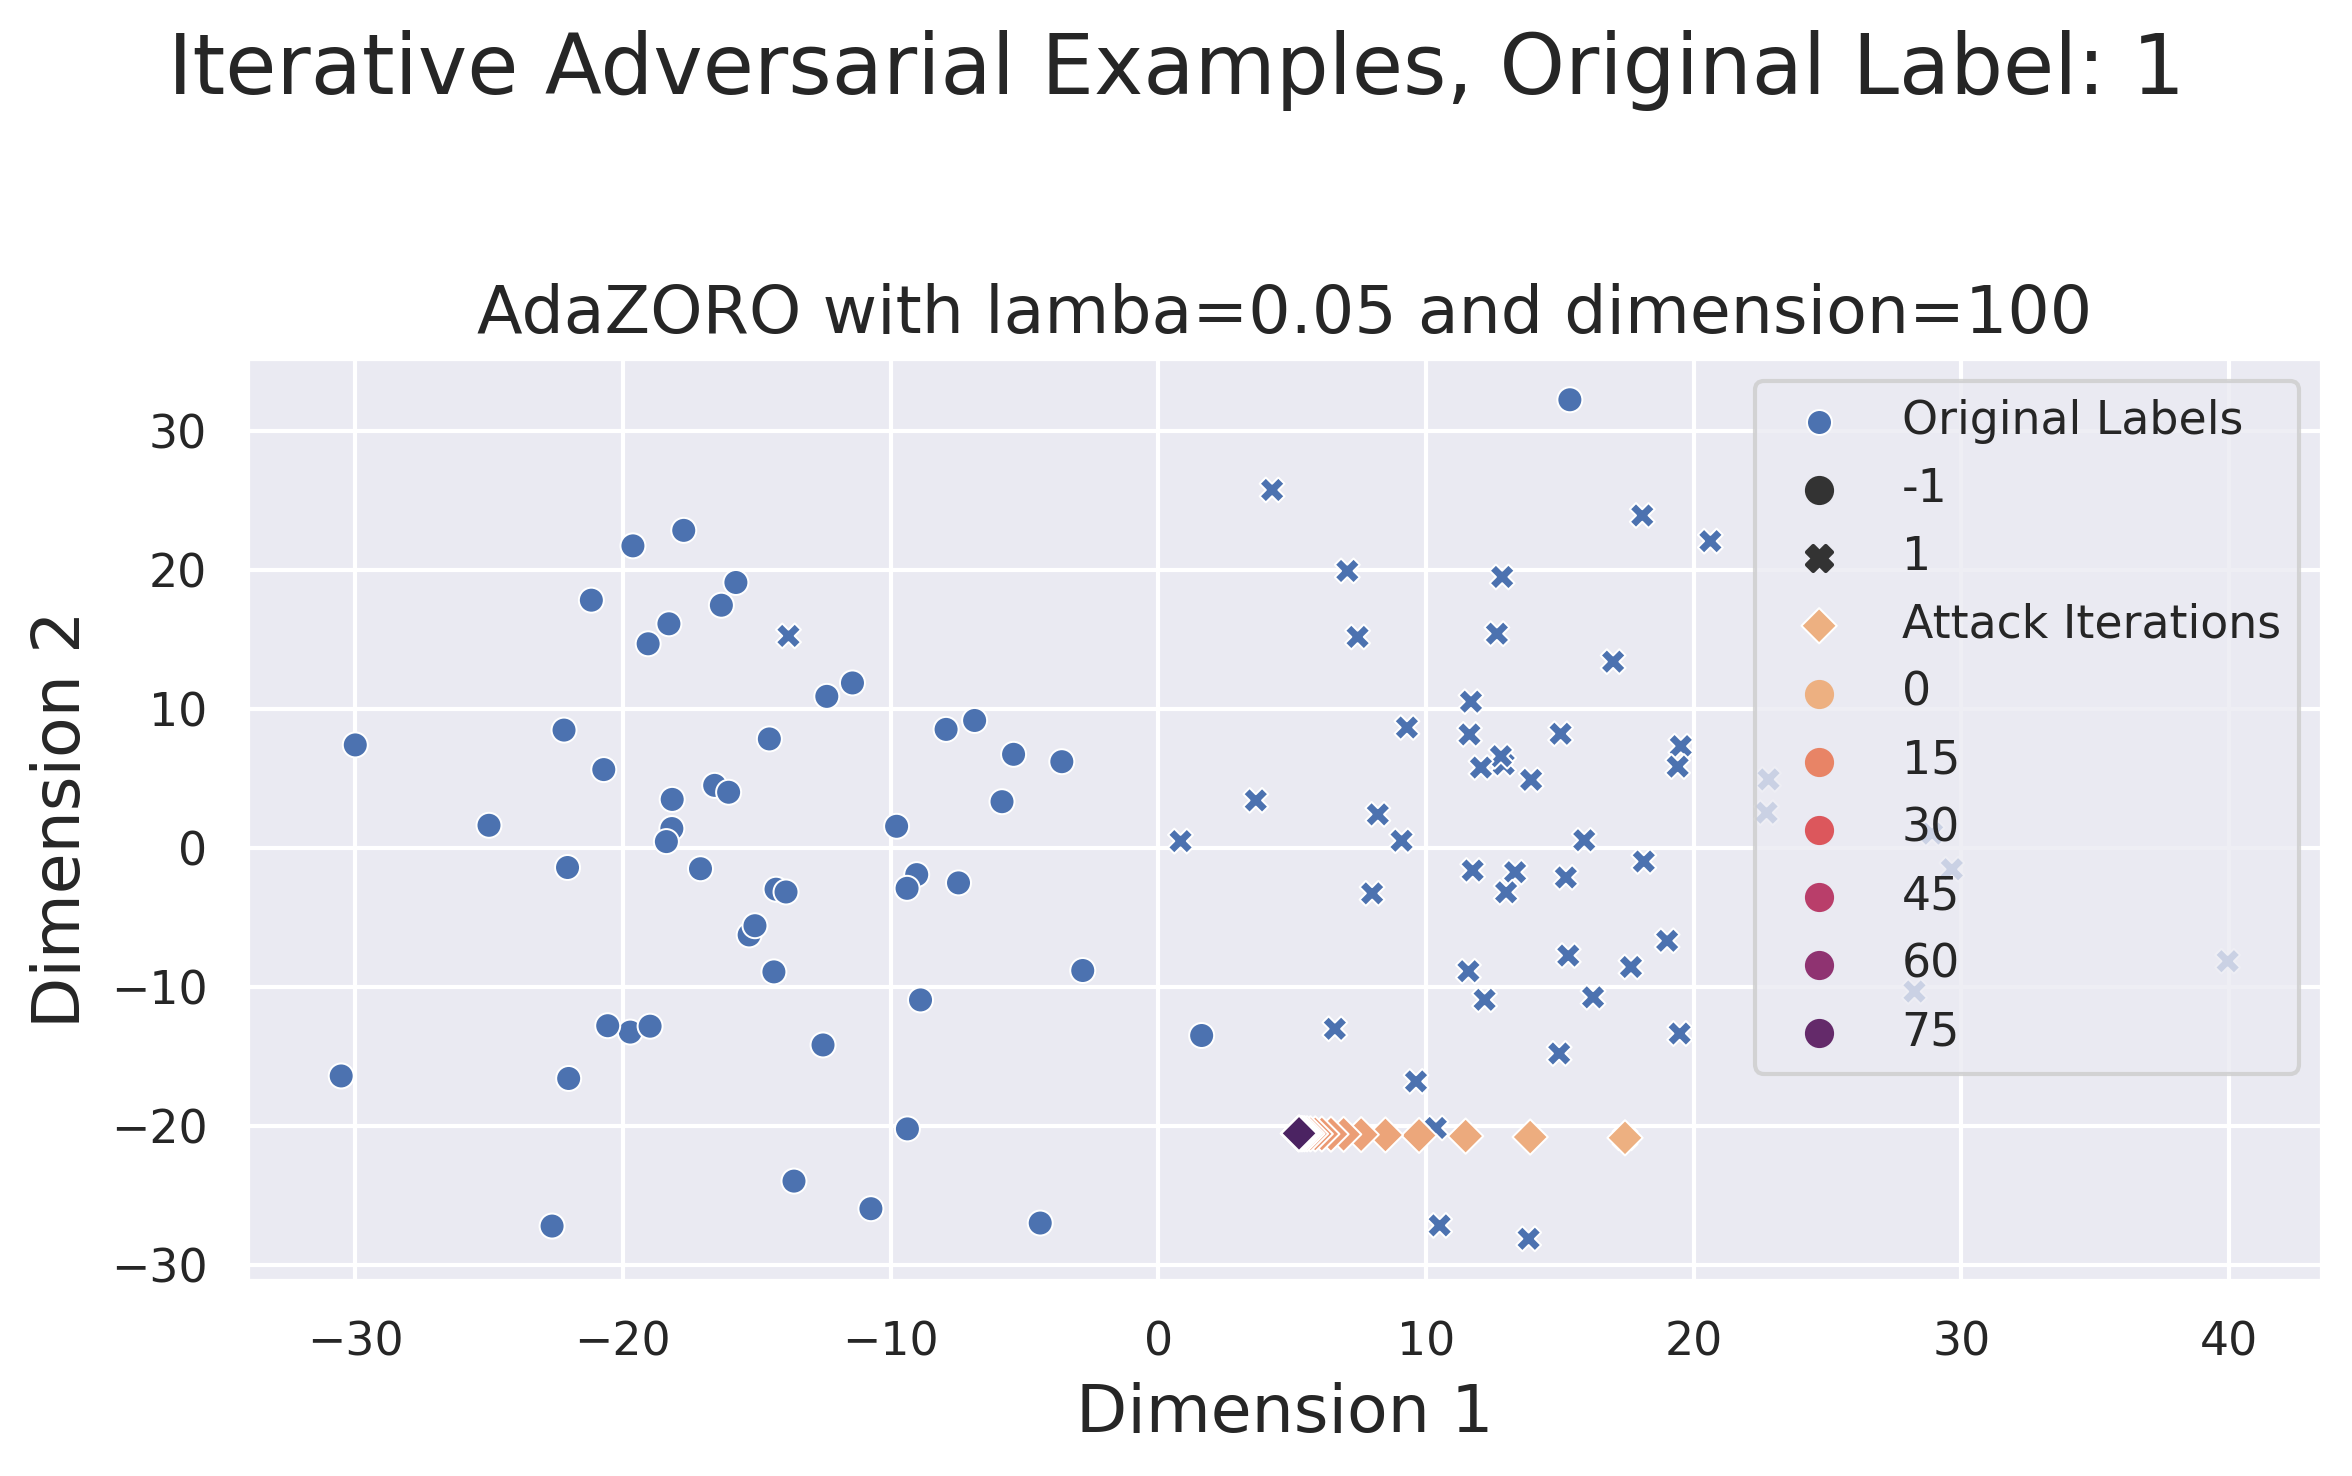

In [236]:
j = 5
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
ada = True
l = 0.05
d = 100
selected_report = get_raw_report(ada, l, d)

selected_X = np.stack([selected_report[j][i]["x"] for i in range(len(selected_report[j]))])[::10]
reduced_X = pca[100].transform(selected_X)

plt.figure(figsize=(8,5), dpi=300)
plt.suptitle(f"Iterative Adversarial Examples, Original Label: {selected_report[j][0]['y']}\n", size=20)
plt.title(f"{'AdaZORO' if ada else 'ZORO'} with lamba={l} and dimension={d}", size=16)
plt.xlabel("Dimension 1", size=16)
plt.ylabel("Dimension 2", size=16)
sns.scatterplot(x=X_reduced[100][:,0], y=X_reduced[100][:,1], style=y[100], label="Original Labels")
sns.scatterplot(x=reduced_X[:, 0], y=reduced_X[:, 1], hue=range(len(reduced_X)), marker="D", palette="flare", label="Attack Iterations")
plt.tight_layout()



plt.savefig("gaussian_dim100_path.pdf")

#### Fig 2

Distance from Hyperplane (Vector Norm)

<Figure size 1800x300 with 0 Axes>

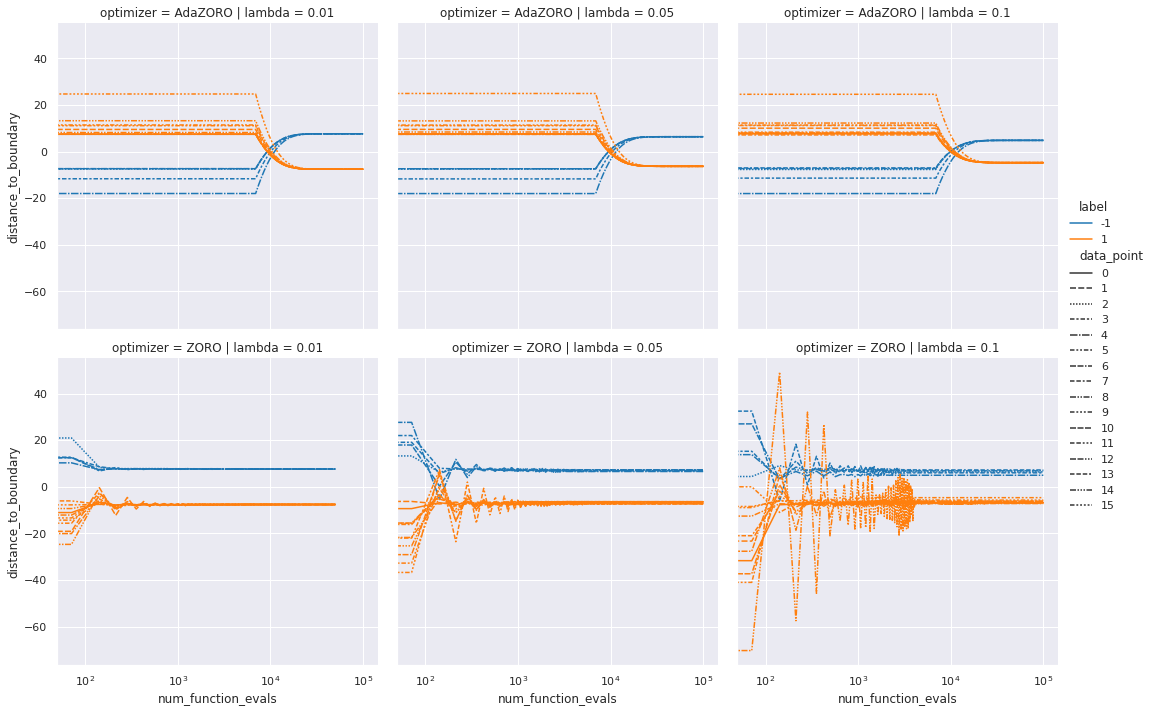

In [241]:
plt.figure(figsize=(6, 1), dpi=300)

sns.set(font_scale=1)

g = sns.relplot(
    data=report_all, x="num_function_evals", y="distance_to_boundary",
    row="optimizer", col="lambda", hue="label", style="data_point",
    kind="line", palette="tab10"
)
plt.xscale("log")

plt.savefig("gaussian_dim100_distance_norm.pdf")

#### Fig 3

Distance from Input to Attack Vector (Vector Norm)

<Figure size 1800x300 with 0 Axes>

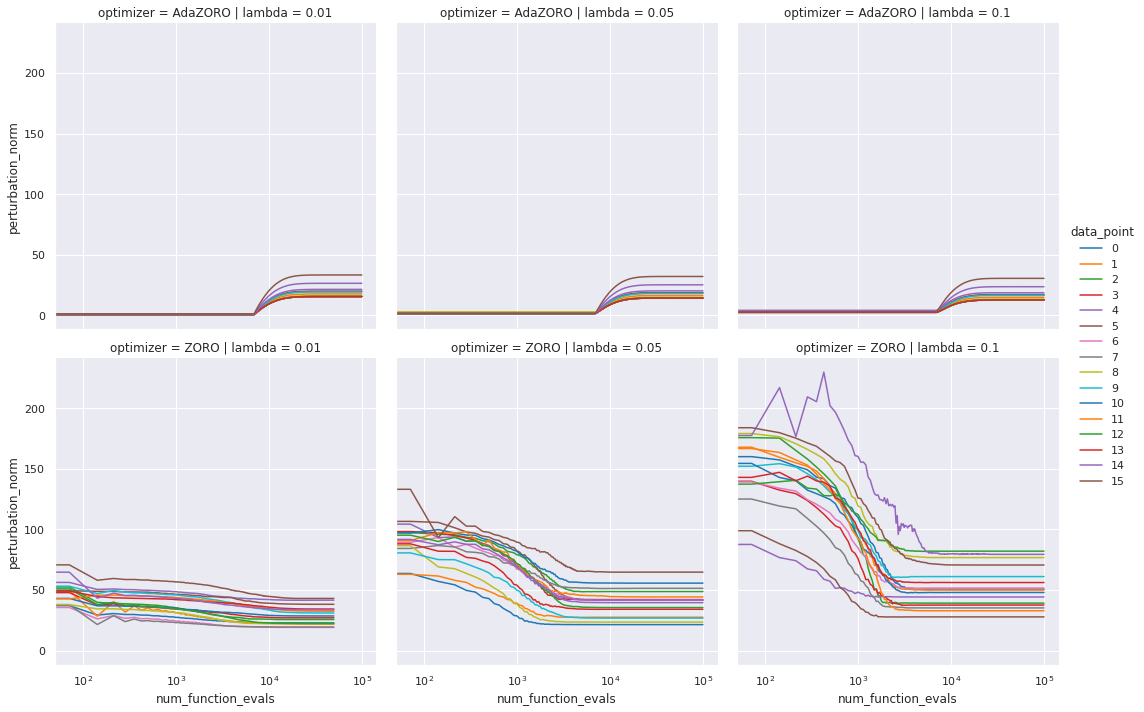

In [242]:
plt.figure(figsize=(6, 1), dpi=300)

sns.relplot(
    data=report_all, x="num_function_evals", y="perturbation_norm",
    row="optimizer", col="lambda", hue="data_point",
    kind="line", palette="tab10"
)
plt.xscale("log")

plt.savefig("gaussian_dim100_perturb_norm.pdf")

In [26]:
import FashionMNIST.utils as fashionmnist_utils
import os
from torchvision import transforms
import torch

def compile_report_fashion(path):
    report = torch.load(path)
    
    data_point = []

    iteration = []
    number_evals = []
    perturbation_norms = []
    predictions = []
    labels = []
    changed_images = []

    model = fashionmnist_utils.get_model(os.path.join('FashionMNIST', 'model', 'resnet.pt'), torch.device('cpu'))

    for i in range(len(report)):
        data_point.extend([i] * len(report[i]))
        original = report[i][0]["x"]
        labels.extend([report[i][0]["y"]] * len(report[i]))
        results = [report[i][j]["x"] + original for j in range(len(report[i]))]

        iteration.extend(range(len(report[i])))
        number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
        perturbation_norms.extend([np.linalg.norm(original - results[j], 2) for j in range(len(report[i]))])
        
        # use the data and model to get the predicted label
        pred_classes = []
        for image in results:
            image_3channels = transforms.Lambda(lambda x: torch.tensor(x).repeat(1, 3, 1, 1))(image)
            with torch.no_grad():
                output = model(image_3channels.type(torch.FloatTensor))
            pr = torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()
            pred_classes += [np.argmax(pr)]

        predictions.extend(pred_classes)
        changed_images.extend(results)

    results_df = pd.DataFrame(
        {**{"data_point" : data_point,
         "iteration" : iteration,
         "num_function_evals": number_evals,
         "perturbation_norm": perturbation_norms,
         "distance_to_boundary": predictions,
         "label" : labels,
         "optimizer": len(labels) * ["AdaZORO" if False else "ZORO"],
         "lambda" : len(labels) * [0.01],
         "dimensionality" : len(labels) * [784]
        },
        **{f'pixel_{i}': row for i, row in enumerate(np.vstack(changed_images).T)}}
    )
    results_df.to_csv('report_thingy.csv')
    return results_df

In [27]:
results = compile_report_fashion('ZORO_lamb0_0_1_report.pt')
pixel_cols = results.columns[results.columns.str.contains('pixel')]
imgs = [r.reshape((28, 28)) for r in results[pixel_cols].to_numpy()]

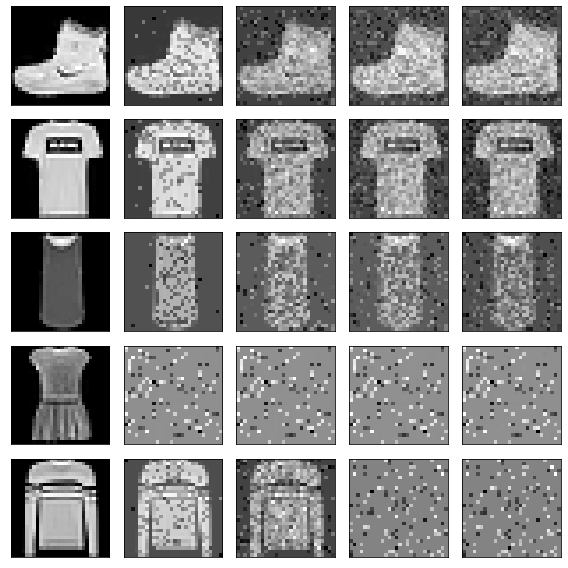

In [30]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
ax = axes.ravel()
j = 0
for i, im in zip(range(len(imgs)), imgs):
    try:
        if (i % 14 in [0, 13] or (i % 14 - 1) % 4 == 0):
            img = (im + im.min()) / im.max()    
            ax[j].imshow(img, cmap='gray')
            ax[j].set_xticks([])
            ax[j].set_yticks([])
            j += 1
    except IndexError:
        break
plt.tight_layout()
plt.savefig('fashion_resulting_images.pdf')
